In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
INPUT_PATH = "/content/drive/MyDrive/Data/LevelUp/data/"

In [17]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.85, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.85, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),

}

In [18]:
image_datasets = {
    'train': datasets.ImageFolder(INPUT_PATH+'train', data_transforms['train']),
    'validation': datasets.ImageFolder(INPUT_PATH+'validation', data_transforms['validation']),
}

In [19]:
dataloaders = {
    'train': 
    torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle = True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle = False)
}

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda', index=0)

In [22]:
model = models.resnet101(pretrained = True).to(device)
for param in model.parameters():
  param.requires_grad = False


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [25]:
def train_model(model, criterion, optimizer, num_epochs=3):

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("_"*10)

    for phase in ['train', 'validation']:
      if phase == 'train':
         model.train()
      else:
         model.eval()

      running_loss = 0.0
      running_corrects = 0
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss/ len(image_datasets[phase])
      epoch_acc = running_corrects.double() / len(image_datasets[phase])

      print ('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

  return model

In [26]:
model_trained = train_model(model, criterion, optimizer, num_epochs = 30)

Epoch 1/30
__________
train loss: 0.5663, acc: 0.6859
validation loss: 0.3404, acc: 0.9150
Epoch 2/30
__________
train loss: 0.2750, acc: 0.9020
validation loss: 0.3123, acc: 0.8400
Epoch 3/30
__________
train loss: 0.2433, acc: 0.9006
validation loss: 0.2399, acc: 0.9100
Epoch 4/30
__________
train loss: 0.1716, acc: 0.9366
validation loss: 0.2194, acc: 0.9300
Epoch 5/30
__________
train loss: 0.1879, acc: 0.9207
validation loss: 0.2266, acc: 0.9250
Epoch 6/30
__________
train loss: 0.1556, acc: 0.9366
validation loss: 0.2090, acc: 0.9250
Epoch 7/30
__________
train loss: 0.1267, acc: 0.9481
validation loss: 0.2300, acc: 0.9250
Epoch 8/30
__________
train loss: 0.1767, acc: 0.9179
validation loss: 0.3825, acc: 0.8250
Epoch 9/30
__________
train loss: 0.1616, acc: 0.9323
validation loss: 0.2134, acc: 0.9150
Epoch 10/30
__________
train loss: 0.1359, acc: 0.9481
validation loss: 0.2138, acc: 0.9200
Epoch 11/30
__________
train loss: 0.1294, acc: 0.9438
validation loss: 0.2202, acc: 0.90

In [30]:
!mkdir models/pytorch

In [31]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [32]:
model = models.resnet101(pretrained = False).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

model.load_state_dict(torch.load("models/pytorch/weights.h5"))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [60]:
validation_img_paths = ["validation/alien/33.jpg","validation/alien/77.jpg",
                        "validation/predator/45.jpg","validation/predator/62.jpg"]
img_list = [Image.open(INPUT_PATH + img_path) for img_path in validation_img_paths]

In [61]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])

In [62]:
validation_batch.shape

torch.Size([4, 3, 224, 224])

In [63]:
pred_logits_tensor = model(validation_batch)

In [64]:
pred_logits_tensor

tensor([[ 2.8127, -2.9557],
        [ 3.7783, -3.9402],
        [-3.0582,  2.5146],
        [-0.1847,  0.0762]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [65]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

In [66]:
pred_probs

array([[9.9688512e-01, 3.1148619e-03],
       [9.9955565e-01, 4.4432425e-04],
       [3.7853480e-03, 9.9621469e-01],
       [4.3514162e-01, 5.6485838e-01]], dtype=float32)

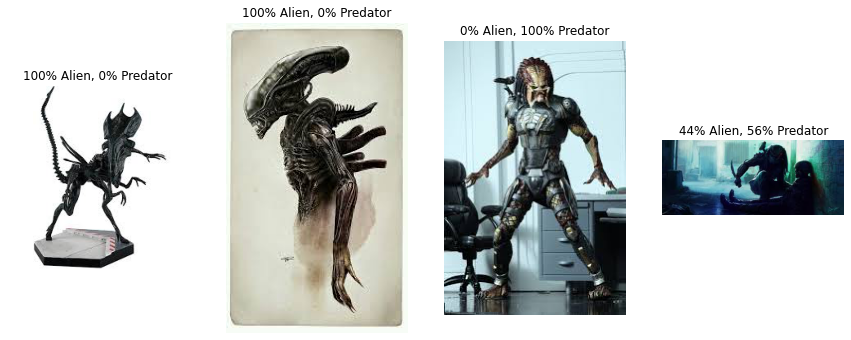

In [67]:
fig, axs = plt.subplots(1, len(img_list), figsize=(15, 10))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)